In [36]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import os

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
from google.colab import drive
drive.mount('/content/drive')

#Append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'Colab Notebooks/'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)

resume = os.path.join(sys_path, 'Resume.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df = pd.read_csv(resume)
del df['ID']
del df['Resume_html']
df.head()

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


Preprocess function adapted from: Labib, H. (2022, April 17). Resume extraction. Kaggle. Retrieved May 4, 2022, from https://www.kaggle.com/code/hendlabib12/resume-extraction/notebook 

In [39]:
STEMMER = nltk.stem.porter.PorterStemmer()
def preprocess(txt):
    # convert all characters in the string to lower case
    txt = txt.lower()
    # remove non-english characters, punctuation and numbers
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)  # remove URLs
    txt = re.sub('RT|cc', ' ', txt)  # remove RT and cc
    txt = re.sub('#\S+', '', txt)  # remove hashtags
    txt = re.sub('@\S+', '  ', txt)  # remove mentions
    txt = re.sub('\s+', ' ', txt)  # remove extra whitespace
    # tokenize word
    txt = nltk.tokenize.word_tokenize(txt)
    # remove stop words
    txt = [STEMMER.stem(w) for w in txt if not w in nltk.corpus.stopwords.words('english')]
    # stemming

    return ' '.join(txt)

In [40]:
# preprocessing text
df['Resume'] = df['Resume_str'].apply(lambda w: preprocess(w))
# drop original text column
del df['Resume_str']
df

,Category,Resume
0,HR,hr administr market associ hr administr summar...
1,HR,hr specialist us hr oper summari versatil medi...
2,HR,hr director summari year experi recruit plu ye...
3,HR,hr specialist summari dedic driven dynam year ...
4,HR,hr manag skill highlight hr skill hr depart st...
...,...,...
2479,AVIATION,rank sgt e non commiss offic charg brigad mail...
2480,AVIATION,govern relat commun organiz develop director p...
2481,AVIATION,geek squad agent profession profil support spe...
2482,AVIATION,program director offic manag summari highli pe...


In [39]:
dataset_bal = np.unique(df['Category'], return_counts=True)

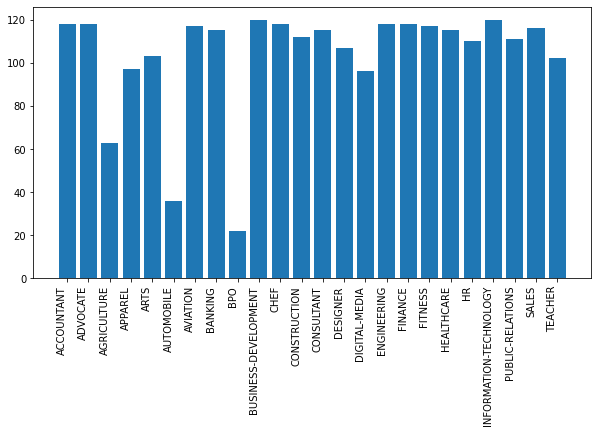

In [46]:
plt.figure(figsize=(10, 5))
plt.bar(dataset_bal[0], dataset_bal[1])
plt.xticks(rotation=90, ha='right')
plt.show()

In [41]:
df.to_csv(os.path.join(sys_path, 'Resume_preprocess.csv'))

<h1>KNN Neighbour with over-sampling</h1>

In [167]:
df = pd.read_csv(os.path.join(sys_path, 'Resume_preprocess.csv'), index_col=0)
df.dropna(inplace=True)
label_cls = df['Category'].unique()
num_cls = len(label_cls)
label_cls_dict = dict(zip(label_cls, list(range(num_cls))))
df['Category'] = df.Category.apply(lambda x: label_cls_dict[x])

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer
df.dropna(inplace=True)
resume_vals = df['Resume'].values
categories = df['Category'].values
tfvec = TfidfVectorizer(sublinear_tf=True)
tfvec.fit(resume_vals)
resume_tokens = tfvec.transform(resume_vals)

In [169]:
from imblearn.over_sampling import RandomOverSampler

seed = 100
sm = RandomOverSampler(sampling_strategy='auto', random_state=seed)
resume_tokens, categories = sm.fit_resample(resume_tokens, categories)


In [170]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(resume_tokens, categories,random_state=42, test_size=0.2,
                                                 shuffle=True, stratify=categories)

knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [171]:
from sklearn import metrics

y_pred = knn.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))

Accuracy with K-NN: 53.65%


<h1>Deep Learning</h1>
Deep learning adapted from: Labib, H. (2022, April 17). Resume extraction. Kaggle. Retrieved May 4, 2022, from https://www.kaggle.com/code/hendlabib12/resume-extraction/notebook 

In [3]:
df = pd.read_csv(os.path.join(sys_path, 'Resume_preprocess.csv'), index_col=0)
df.dropna(inplace=True)

features = df['Resume'].values
original_labels = df['Category'].values
labels = original_labels[:]
for i in range(len(df)):
    labels[i] = str(labels[i].lower())  # convert to lowercase
    labels[i] = labels[i].replace("-", "")  # use hyphens to convert multi-token labels into single tokens
    
from sklearn.utils import shuffle
features, labels = shuffle(features, labels)

In [153]:
# Split for train and test
train_split = 0.8
train_size = int(train_split * len(df))

train_features = features[:train_size]
train_labels = labels[:train_size]

test_features = features[train_size:]
test_labels = labels[train_size:]

# Print size of each split
print(len(train_labels))
print(len(test_labels))

1986
497


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize feature data
vocab_size = 6000
oov_tok = '<>'

feature_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
feature_tokenizer.fit_on_texts(features)

feature_index = feature_tokenizer.word_index
features = feature_tokenizer.texts_to_sequences(features)

# train_feature_sequences = feature_tokenizer.texts_to_sequences(train_features)

# test_feature_sequences = feature_tokenizer.texts_to_sequences(test_features)

In [8]:
# Tokenize label data 
label_tokenizer = Tokenizer(lower=True)
label_tokenizer.fit_on_texts(labels)

labels = label_tokenizer.texts_to_sequences(labels)

In [11]:
# Split for train and test
train_split = 0.8
train_size = int(train_split * len(df))

train_features = features[:train_size]
train_labels = labels[:train_size]

test_features = features[train_size:]
test_labels = labels[train_size:]

In [12]:
# Pad sequences for feature data
max_length = 625
trunc_type = 'post'
pad_type = 'post'

train_feature_padded = pad_sequences(train_features, maxlen=max_length, padding=pad_type, truncating=trunc_type)
test_feature_padded = pad_sequences(test_features, maxlen=max_length, padding=pad_type, truncating=trunc_type)

In [30]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
embedding_dim = 64

model = tf.keras.Sequential([
  # Add an Embedding layer expecting input vocab of size 6000, and output embedding dimension of size 64 we set at the top
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=625),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  # use ReLU in place of tanh function since they are very good alternatives of each other.
  tf.keras.layers.Dense(embedding_dim, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(embedding_dim, activation='relu'),
  tf.keras.layers.Dropout(0.5),

  # Add a Dense layer with 25 units and softmax activation for probability distribution
  tf.keras.layers.Dense(25, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 625, 64)           384000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                      

In [14]:
import numpy as np
# Compile the model and convert train/test data into NumPy arrays
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Features
train_feature_padded = np.array(train_feature_padded)
# train_feature_padded = train_feature_padded.reshape(-1, 25, 25, 1)
test_feature_padded = np.array(test_feature_padded) 
# test_feature_padded = test_feature_padded.reshape(-1, 25, 25, 1)
# Labels
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
num_epochs = 12

history = model.fit(train_feature_padded, train_labels, epochs=num_epochs, 
                    validation_data=(test_feature_padded, test_labels), verbose=2)

Epoch 1/12
63/63 - 99s - loss: 3.1997 - accuracy: 0.0564 - val_loss: 3.1606 - val_accuracy: 0.1247 - 99s/epoch - 2s/step
Epoch 2/12
63/63 - 43s - loss: 3.0885 - accuracy: 0.0947 - val_loss: 2.9350 - val_accuracy: 0.1791 - 43s/epoch - 681ms/step
Epoch 3/12
63/63 - 43s - loss: 2.7401 - accuracy: 0.1767 - val_loss: 2.3748 - val_accuracy: 0.3159 - 43s/epoch - 675ms/step
Epoch 4/12
63/63 - 42s - loss: 2.3014 - accuracy: 0.3051 - val_loss: 1.9190 - val_accuracy: 0.5171 - 42s/epoch - 671ms/step
Epoch 5/12
63/63 - 44s - loss: 1.9822 - accuracy: 0.4220 - val_loss: 1.5483 - val_accuracy: 0.6016 - 44s/epoch - 692ms/step
Epoch 6/12
63/63 - 41s - loss: 1.6622 - accuracy: 0.5091 - val_loss: 1.3856 - val_accuracy: 0.6378 - 41s/epoch - 654ms/step
Epoch 7/12
63/63 - 41s - loss: 1.4782 - accuracy: 0.5619 - val_loss: 1.2844 - val_accuracy: 0.6539 - 41s/epoch - 656ms/step
Epoch 8/12
63/63 - 51s - loss: 1.3223 - accuracy: 0.6012 - val_loss: 1.2567 - val_accuracy: 0.6539 - 51s/epoch - 814ms/step
Epoch 9/12


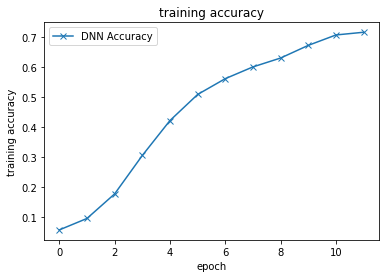

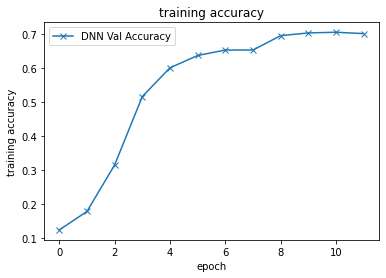

In [35]:
plt.plot(history.history['accuracy'], 'x-', label = 'DNN Accuracy')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
plt.plot(history.history['val_accuracy'], 'x-', label = 'DNN Val Accuracy')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()